In [2]:
import csv
import os
import numpy as np
import re
import argparse
import sys
from sklearn import feature_extraction, decomposition
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE


In [ ]:
def create_vocabulary(indir, outdir, level=None):
    headers = _load_data(indir, 'header-tables.csv')
    cscores = _load_data(indir, 'person_scores.csv') # [ins_str, age in yrs, sex, DOB, DOA, ...]
    
    # behavioral ehrs (create vocabulary terms)
    behr = {}
    for lab, ins in cscores.items():
        for el in ins:
            if bool(re.match('ados', el[0])):
                tmp = el[0:3] + ['::'.join(['ados', 
                                            headers[el[0]][idx-1], 
                                            el[idx]]) for idx in range(6, len(el)) if el[idx] != '']
            elif bool(re.match('vin|psi|srs', el[0])):
                tmp = el[0:3] + ['::'.join([el[0],
                                            el[6],
                                            headers[el[0]][idx-1], 
                                            el[idx]]) for idx in range(7, len(el)) if el[idx] != '']
            else:
                tmp = el[0:3] + ['::'.join([el[0], headers[el[0]][idx-1], 
                                            el[idx]]) for idx in range(6, len(el)) if el[idx] != '']
        behr.setdefault(lab, list()).append(tmp)
    behr[lab] = sorted(behr[lab], key=lambda x: (x[1], x[0]))
    
    # select the depth of scores
    deep_behr = {}
    if level == 1:
        for lab, ins in behr.items():
            for el in ins:
                if bool(re.match('wa|wi|leit', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('scaled', x)), el))
                elif bool(re.match('vinel', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('scaled', x)), el))
                elif bool(re.match('ados-2modulo[1|T]', el[0])):
                    tmp = list(filter(lambda x: bool(re.search('\.[a|b]', x)), el))
                    tmp = el[0:3] + list(map(lambda x: '::'.join(['ados', x.split('.')[1]]),tmp)) 
                elif bool(re.match('ados-2modulo[2|3|4]', el[0])):
                    tmp = list(filter(lambda x: not(bool(re.search('tot|score|lang|algor', x))), 
                               el))
                elif bool(re.match('psi|srs', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('raw', x)) 
                                                          and not(bool(re.search('raw_dr|raw_ts|raw_tot', x))), 
                                                el))
                else:
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('q_', x)), el))
            deep_behr.setdefault(lab, list()).append(tmp)
    elif level == 2:
        for lab, ins in behr.items():
            for el in ins:
                if bool(re.match('wa|wi', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('sumScaled_[PR|VC|V|P|WM|PS|PO|GL]', x)), el))
                elif bool(re.match('leit', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('scaled', x)), el)) # rimane lo stesso anche LEITER
                elif bool(re.match('vinel', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('sum_', x)), el))
                elif bool(re.match('ados-2modulo[1|T]', el[0])):
                    tmp = list(filter(lambda x: bool(re.search('\.[sa_tot|rrb_tot]', x)), el))
                    tmp = el[0:3] + list(map(lambda x: '::'.join(['ados', x.split('.')[1]]),tmp)) 
                elif bool(re.match('ados-2modulo[2|3]', el[0])):
                    tmp = list(filter(lambda x: not(bool(re.search('sarrb_tot|a|b|score|lang|algor', x))), 
                               el))
                elif bool(re.match('ados-2modulo4', el[0])):
                    tmp = list(filter(lambda x: bool(re.search('comm_|::si_|sbri_', x)), el))
                    tmp = el[0:3] + list(map(lambda x: '::'.join(['ados-m4', x]), tmp)) 
                elif bool(re.match('psi|srs', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('raw', x)) 
                                                          and not(bool(re.search('raw_dr|raw_ts|raw_tot', x))), 
                                                el)) # rimangono come al livello 1
                else:
                    # GMDS rimangono i quozienti al secondo livello
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('q_', x)), el))
            deep_behr.setdefault(lab, list()).append(tmp)
    else:
        for lab, ins in behr.items():
            for el in ins:
                if bool(re.match('wa|wi|leit', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('sumScaled_FS', x)), el))
                elif bool(re.match('leit', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('sumScaled_[fr|BIQ]]', x)), el))
                elif bool(re.match('vinel', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('standard_ABC', x)), el))
                elif bool(re.match('ados-2modulo[1]', el[0])):
                    tmp = list(filter(lambda x: bool(re.search('\.sarrb_tot', x)), el))
                    tmp = el[0:3] + list(map(lambda x: '::'.join(['ados', x.split('.')[1]]),tmp)) 
                elif bool(re.match('ados-2modulo[2|3|T]', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('sarrb_tot', x)), 
                               el))
                elif bool(re.match('ados-2modulo4', el[0])):
                    tmp = list(filter(lambda x: bool(re.search('commsi_|sbri_', x)), el))
                    tmp = el[0:3] + list(map(lambda x: '::'.join(['ados-m4', x]), tmp)) 
                elif bool(re.match('psi|srs', el[0])):
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('raw_[ts|tot]', x)) 
                                                          and not(bool(re.search('raw_dr', x))), 
                                                el))
                else:
                    tmp = el[0:3] + list(filter(lambda x: bool(re.search('GQ', x)), el))
            deep_behr.setdefault(lab, list()).append(tmp)
            
    lab_to_idx = idx_to_lab = {}
    idx = 0
    for lab, seq in deep_behr.items():
        for vec in seq:
            for v in vec[3::]:
                if v not in lab_to_idx:
                    lab_to_idx[v] = idx
                    idx_to_lab[idx] = v
                    idx += 1
                    
    # write files
    with open(os.path.join(outdir, 'cohort-behr.csv'), 'w') as f:
    wr = csv.writer(f)
    wr.writerow(['ID_SUBJ', 'EVAL_AGE', 'TERM'])
    for lab, seq in deep_behr.items():
        for s in seq:
            for idx in range(6, len(s)):
                wr.writerow([lab, s[1], vocab[s[idx]]])
                
    with open(os.path.join(outdir, 'cohort-vocab.csv'), 'w') as f:
    wr = csv.writer(f)
    wr.writerow(['LABEL', 'INDEX'])
    for l, idx in lab_to_idx.items():
        wr.writerow([l, idx])


In [ ]:
"""
Private Functions
"""

def _load_data(indir, file):
    with open(os.path.join(indir, file)) as f:
        rd = csv.reader(f)
        mydict = {r[0]:r[1::] for r in rd}

In [ ]:
"""
Main Function
"""

def _process_args():
    parser = argparse.ArgumentParser(
             description='create vocabulary for behavioral phenotype,' 
                         ' 3 possible levels')
    parser.add_argument(dest='indir', help='data directory')
    parser.add_argument(dest='level', help='choose behavioral profile depth')
    return parser.parser_args(sys.argv[1:])


if __name__ == '__main__':
    args = _process_args()
    print('')
    
    start = time()
    outdir = os.path.join(indir, 'level-{0}'.format(args.level))
    os.makedirs(outdir)
    create_vocabulary(indir=args.indir,
                      outdir=outdir,
                      level=args.level)

In [9]:
tfidf_mtx = np.zeros([len(behr1l), len(vocab)], dtype=int)

In [10]:
tfidf_mtx.shape

(247, 2118)

In [133]:
raw_behr = {}
tfidf_mtx = []
for idx, (lab, ehr) in enumerate(behr1l.items()):
    tmp = []
    for vec in ehr:
        for v in vec[3::]:
            tmp.append(str(vocab[v]))
    tfidf_mtx.append(' '.join([t for t in tmp]))
    raw_behr[lab] = [int(t) for t in tmp]

In [134]:
len(tfidf_mtx)

247

In [135]:
tfidf = feature_extraction.text.TfidfVectorizer()
tfidf_mtx = tfidf.fit_transform(tfidf_mtx)

In [136]:
# tfidf.get_feature_names()

In [137]:
tfidf_mtx.shape

(247, 2108)

In [138]:
svd = decomposition.TruncatedSVD(n_components=10)
svd_mtx = svd.fit_transform(tfidf_mtx)

In [139]:
svd_mtx

array([[ 1.31869994e-01, -2.04072689e-01,  7.71112297e-02, ...,
         3.94109029e-03, -9.59615593e-02, -5.16261854e-02],
       [ 2.60673965e-01, -1.98629203e-01, -1.06560672e-02, ...,
        -6.41484063e-02,  7.74631539e-03,  4.12213915e-02],
       [ 1.65661987e-01, -2.62739221e-01,  5.76993695e-02, ...,
        -8.29491019e-02,  4.58630596e-02, -1.03072009e-01],
       ...,
       [ 6.02403484e-03, -1.24929475e-02, -2.41781568e-04, ...,
        -2.94591601e-04, -2.86743141e-02,  1.80646153e-02],
       [ 9.85959033e-04, -2.54196122e-03,  1.10968268e-03, ...,
        -8.55505080e-04, -1.17443585e-02,  5.71116979e-03],
       [ 5.96680283e-02,  1.83428195e-02, -1.35935562e-01, ...,
        -2.49568755e-01,  1.09825847e-02,  1.13993081e-01]])

In [140]:
silh_best = 0
for n_clu in range(2,20):
    HCalg = AgglomerativeClustering(n_clu)
    hc_lab = HCalg.fit_predict(svd_mtx)
    silh_tmp = silhouette_score(svd_mtx, hc_lab)
    print(silh_tmp)
    if silh_tmp > silh_best:
        silh_best = silh_tmp
        best_nclu = n_clu
        best_hclab = hc_lab

0.16614831575757247
0.1964337607037473
0.1985862807712355
0.20883881708771712
0.20419160713183035
0.21641415568040978
0.23549154044446394
0.21684030566898893
0.217113389473934
0.21251519840374872
0.21344627941247885
0.21539929044739764
0.21846270692000513
0.22158967524677306
0.21582376977343556
0.22183777044541014
0.22082723865308052
0.2225061865211414


In [141]:
print(best_nclu, silh_best)

8 0.23549154044446394


In [142]:
np.unique(best_hclab, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([23, 46, 47, 28, 36, 32,  9, 26]))

In [143]:
def FreqDict(tokens):
    freq_dict = {}
    tok = []
    for seq in tokens:
        tok.extend(seq)
    tok = set(tok)
    for t in tok:
        for seq in tokens:
            if t in seq:
                if t not in freq_dict:
                    freq_dict[t] = 1
                else:
                    freq_dict[t] += 1
    return freq_dict

def freq_term(data, pred_class, vocab, raw_ehr):
    list_terms = []
    for subc in range(len(set(pred_class))):
        tmp_data = {}
        for j in range(len(pred_class)):
            if pred_class[j] == subc:
                tmp_data.setdefault(subc, list()).append([rd for rd in data[j] 
                                                           if rd!=0])
        print("Cluster {0} numerosity: {1}".format(subc, len(tmp_data[subc])))
        term_count = FreqDict(tmp_data[subc])
        clust_mostfreq = []
        for l in range(20):
            try:
                MFMT = max(term_count, key=(lambda key: term_count[key]))
                num_MFMT = 0
                subc_termc = 0
                for ehr in tmp_data[subc]:
                    for e in ehr:
                        if e == MFMT:
                            subc_termc += 1
                for seq in raw_ehr.values():
                    for t in seq:
                        if t == MFMT:
                            num_MFMT += 1
                print("% most frequent term:{0} "
                       "= {1:.2f} ({2} out of {3} terms in the whole dataset"
                       "-- N patients in cluster {4})".format(vocab[MFMT], 
                                                              subc_termc/num_MFMT, 
                                                              subc_termc,
                                                              num_MFMT,
                                                              term_count[MFMT]))
                term_count.pop(MFMT)
                clust_mostfreq.append(MFMT)
            except ValueError:
                pass
        print("\n")
        list_terms.append(clust_mostfreq)
    return

In [144]:
freq_term([v for v in raw_behr.values()], best_hclab, idx_to_lab, raw_behr)

Cluster 0 numerosity: 23
% most frequent term:ados::b1::2 = 0.02 (4 out of 224 terms in the whole dataset-- N patients in cluster 4)
% most frequent term:ados::b9::2 = 0.05 (4 out of 80 terms in the whole dataset-- N patients in cluster 4)
% most frequent term:vineland-ii::Madre e Padre insieme::scaled_per::8 = 0.71 (5 out of 7 terms in the whole dataset-- N patients in cluster 4)
% most frequent term:vineland-ii::Madre e Padre insieme::scaled_rec::7 = 0.62 (5 out of 8 terms in the whole dataset-- N patients in cluster 4)
% most frequent term:vineland-ii::Madre e Padre insieme::scaled_exp::4 = 0.70 (7 out of 10 terms in the whole dataset-- N patients in cluster 4)
% most frequent term:vineland-ii::Madre e Padre insieme::scaled_wri::5 = 0.75 (6 out of 8 terms in the whole dataset-- N patients in cluster 4)
% most frequent term:ados::b3::1 = 0.03 (3 out of 90 terms in the whole dataset-- N patients in cluster 3)
% most frequent term:ados::b5::1 = 0.06 (3 out of 53 terms in the whole data

In [145]:
def single_plot(data, mrn_disease, colors, leg_labels=None):
    plt.figure(figsize=(20,10))
    for cl in set(mrn_disease):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j] == cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j] == cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j] == cl]
        plt.xticks([])
        plt.yticks([])
        plt.scatter(x,y,c=cols, label=cl)
    if leg_labels is not None:
        plt.legend(loc=2, labels=leg_labels, markerscale=1, fontsize=9)
    else:
        plt.legend(loc=2, markerscale=1, fontsize=9)

In [146]:
import matplotlib 
from matplotlib import pyplot as plt
% matplotlib inline

col_dict = matplotlib.colors.CSS4_COLORS
c_out = ['mintcream', 'cornsilk', 'lavenderblush', 'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'powderblue', 'floralwhite', 'ghostwhite',
     'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
     'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'linen', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
     'peachpuff', 'mistyrose', 'lemonchiffon', 'lightblue', 'seashell', 'white', 'blanchedalmond', 'oldlace', 'moccasin', 'snow', 'darkgray',
     'ivory', 'whitesmoke']
colormap = [c for c in col_dict if c not in c_out]

In [149]:
colors_en = [colormap[v] for v in best_hclab]
tsne_mtx = TSNE().fit_transform(svd_mtx)

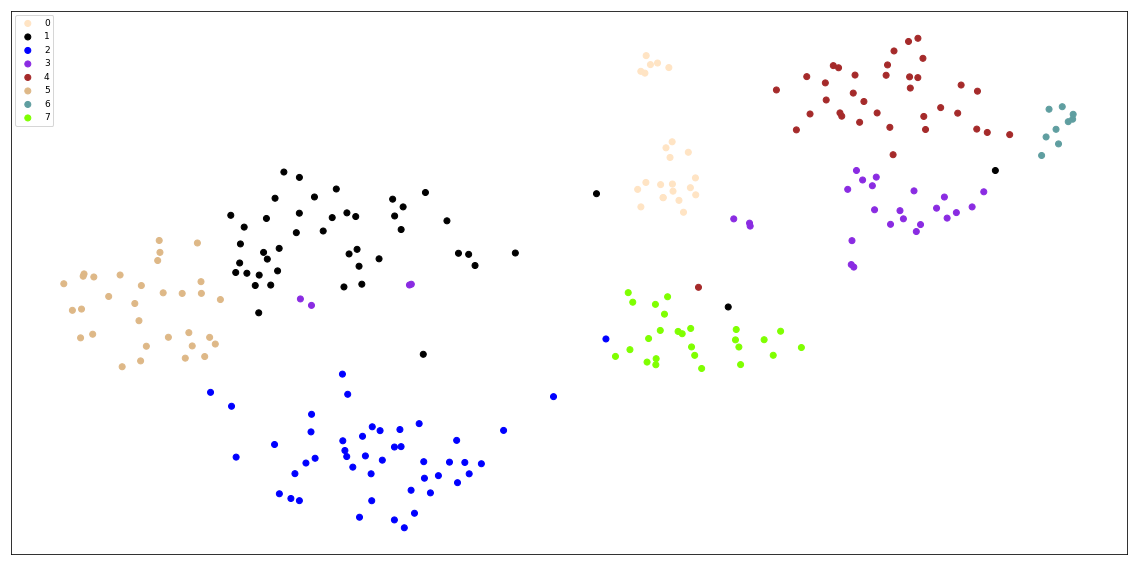

In [150]:
single_plot(tsne_mtx, best_hclab, colors_en)

# Word2vec

In [744]:
list_mrn = [lab for lab in raw_behr]
tokenized_corpus = [vec for vec in raw_behr.values()]

word2idx = vocab
idx2word = idx_to_lab

window_size = 5
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

In [745]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

In [746]:
embedding_dims = 5
vocabulary_size = len(word2idx)

W1 = torch.randn(embedding_dims, vocabulary_size, requires_grad=True).float()
W2 = torch.randn(vocabulary_size, embedding_dims, requires_grad=True).float()
num_epochs = 5
learning_rate = 0.001

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = get_input_layer(data).float()
        y_true = torch.from_numpy(np.array([target])).long()

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

Loss at epo 0: 9.453596194195455


In [747]:
W2.size()

torch.Size([2118, 5])

In [748]:
W1.size()

torch.Size([5, 2118])

In [749]:
behr_emb = {lab:W2[idx].detach().numpy() for lab, idx in raw_behr.items()}

In [750]:
behr_emb_avg = {}
list_emb_avg = []
list_mrn = []
for lab, emb in behr_emb.items():
    if len(emb) > 0:    
        avg_emb = np.mean(emb, 0)
        behr_emb_avg[lab] = avg_emb.tolist()
        list_mrn.append(lab)
        list_emb_avg.append(avg_emb.tolist())

In [751]:
silh_best = 0
for n_clu in range(3,20):
    HCalg = AgglomerativeClustering(n_clu)
    hc_lab = HCalg.fit_predict(list_emb_avg)
    silh_tmp = silhouette_score(list_emb_avg, hc_lab)
    print(silh_tmp)
    if silh_tmp > silh_best:
        silh_best = silh_tmp
        best_nclu = n_clu
        best_hclab = hc_lab

0.23861414856077323
0.25429643090769366
0.15933470780758768
0.16315075006394492
0.17078370440541674
0.17371754342540005
0.17737159783403975
0.1413148557740774
0.13603137950441233
0.1304386265035545
0.13562126629007473
0.14209120844451376
0.14158980336055957
0.14500553660272558
0.14900508597863094
0.15242219893098027
0.15401633610836415


In [752]:
print(best_nclu, silh_best)

4 0.25429643090769366


In [753]:
np.unique(best_hclab, return_counts=True)

(array([0, 1, 2, 3]), array([137,  75,  14,  19]))

In [754]:
freq_term([v for v in raw_behr.values()], best_hclab, idx_to_lab, raw_behr)

Cluster 0 numerosity: 137
% most frequent term:ados::a4::0 = 0.85 (123 out of 144 terms in the whole dataset-- N patients in cluster 110)
% most frequent term:ados::d1::0 = 0.85 (120 out of 142 terms in the whole dataset-- N patients in cluster 107)
% most frequent term:ados::b1::2 = 0.54 (121 out of 224 terms in the whole dataset-- N patients in cluster 105)
% most frequent term:ados::d2::0 = 0.85 (121 out of 143 terms in the whole dataset-- N patients in cluster 105)
% most frequent term:ados::b2::1 = 0.84 (108 out of 128 terms in the whole dataset-- N patients in cluster 97)
% most frequent term:ados::d4::0 = 0.83 (93 out of 112 terms in the whole dataset-- N patients in cluster 84)
% most frequent term:ados::b11::1 = 0.76 (75 out of 99 terms in the whole dataset-- N patients in cluster 72)
% most frequent term:ados::b9::1 = 0.68 (75 out of 110 terms in the whole dataset-- N patients in cluster 70)
% most frequent term:ados::a7::1 = 0.68 (71 out of 105 terms in the whole dataset-- N

In [755]:
colors_en = [colormap[v] for v in best_hclab]
tsne_mtx = TSNE().fit_transform(list_emb_avg)

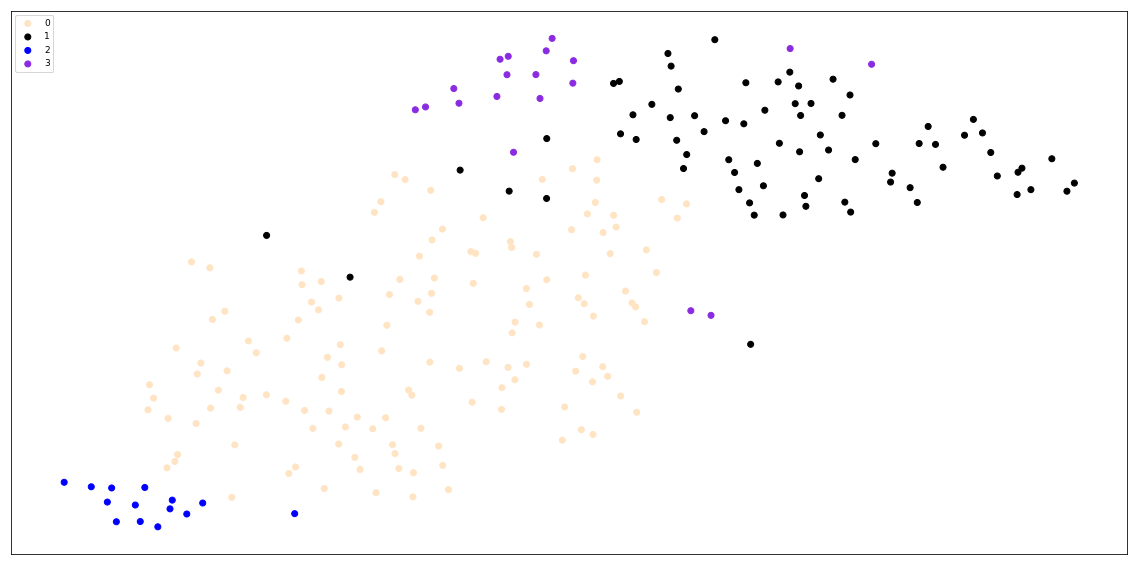

In [756]:
single_plot(tsne_mtx, best_hclab, colors_en)